<a href="https://colab.research.google.com/github/coldfir3/MPA/blob/master/Copy_of_Copy_of_Seti_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [1]:
import sys
import os
is_colab = 'google.colab' in sys.modules

### Downloading data



In [2]:
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/train/'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/seti-spatial-dataset-v1')
        ! kaggle competitions download -c seti-breakthrough-listen -f train_labels.csv
        ! kaggle competitions download -c seti-breakthrough-listen -f sample_submission.csv

Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=19H3_BYiHuzIiY9vo9rBsVIu1aSlPlbKx
To: /content/Kaggle/kaggle.json
100% 64.0/64.0 [00:00<00:00, 57.1kB/s]
drive  Kaggle  sample_data
     |████████████████████████████████| 58 kB 2.9 MB/s 
! kaggle datasets download -d coldfir3/seti-spatial-dataset-v1
100% 11.0G/11.0G [03:33<00:00, 109MB/s] 
100% 11.0G/11.0G [03:33<00:00, 55.4MB/s]
seti-spatial-dataset-v1.zip



  0% 0.00/522k [00:00<?, ?B/s]
100% 522k/522k [00:00<00:00, 115MB/s]
  0% 0.00/781k [00:00<?, ?B/s]
100% 781k/781k [00:00<00:00, 134MB/s]


### Installing packages

In [3]:
if is_colab:
    !pip install -Uqqq wandb
    !pip install -Uqqq fastai
    !pip install -Uqqq timm

     |████████████████████████████████| 1.6 MB 5.3 MB/s 
     |████████████████████████████████| 133 kB 58.7 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 170 kB 64.7 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 188 kB 4.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 376 kB 4.2 MB/s 


### Loading packages

In [4]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
import timm

## Setting up the DataFrames

In [6]:
if is_colab:
    base_path = '/content/test/'
    test_df = pd.read_csv('/content/sample_submission.csv')
test_df['fold'] = -1
test_df['path'] = test_df['id'].apply(lambda x: base_path + x + '.jpg')
test_df

,id,target,fold,path
0,000bf832cae9ff1,0.5,-1,/content/test/000bf832cae9ff1.jpg
1,000c74cc71a1140,0.5,-1,/content/test/000c74cc71a1140.jpg
2,000f5f9851161d3,0.5,-1,/content/test/000f5f9851161d3.jpg
3,000f7499e95aba6,0.5,-1,/content/test/000f7499e95aba6.jpg
4,00133ce6ec257f9,0.5,-1,/content/test/00133ce6ec257f9.jpg
...,...,...,...,...
39990,fff701540fb8aad,0.5,-1,/content/test/fff701540fb8aad.jpg
39991,fff9d92a46ea99a,0.5,-1,/content/test/fff9d92a46ea99a.jpg
39992,fffa40260ffe43d,0.5,-1,/content/test/fffa40260ffe43d.jpg
39993,fffbc626c9d269f,0.5,-1,/content/test/fffbc626c9d269f.jpg


In [7]:
from sklearn.model_selection import StratifiedKFold
if is_colab: 
    base_path = '/content/train/'
    train_df = pd.read_csv('/content/train_labels.csv.zip')
else:
    pass
    # train_study = pd.read_csv('/media/passos/Data/DSET/siim-covid19-detection/train_study_level.csv')

train_df['fold'] = -1
train_df['path'] = train_df['id'].apply(lambda x: base_path + x + '.jpg')
train_df['label'] = train_df['target'].apply(lambda x: 'alien' if x == 1 else 'no-alien')
skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['target'])):
    train_df.loc[test_index, 'fold'] = fold
train_df

,id,target,fold,path,label
0,0000799a2b2c42d,0,3,/content/train/0000799a2b2c42d.jpg,no-alien
1,00042890562ff68,0,3,/content/train/00042890562ff68.jpg,no-alien
2,0005364cdcb8e5b,0,4,/content/train/0005364cdcb8e5b.jpg,no-alien
3,0007a5a46901c56,0,3,/content/train/0007a5a46901c56.jpg,no-alien
4,0009283e145448e,0,3,/content/train/0009283e145448e.jpg,no-alien
...,...,...,...,...,...
59995,fff8217fe05aba3,0,4,/content/train/fff8217fe05aba3.jpg,no-alien
59996,fffa939e610ed70,0,4,/content/train/fffa939e610ed70.jpg,no-alien
59997,fffbb1c9c3d6c31,1,5,/content/train/fffbb1c9c3d6c31.jpg,alien
59998,fffc9a763d23647,0,0,/content/train/fffc9a763d23647.jpg,no-alien


## DataBlock & DataLoader

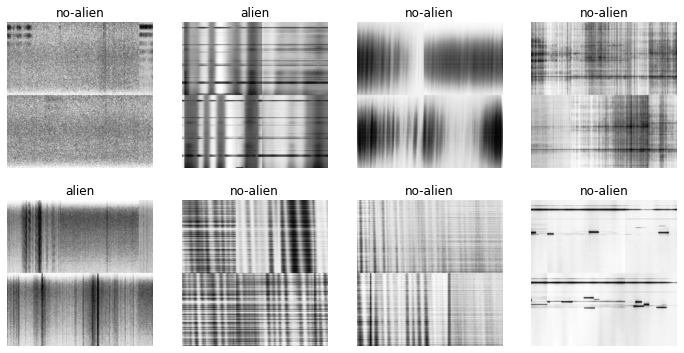

In [8]:
def get_dls(df, **config):
    is_colab = 'google.colab' in sys.modules
    workers = 2 if is_colab else 10
    splitter = IndexSplitter(df[df.fold == config['fold']].index)
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
        splitter = splitter,
        getters=[ColReader('path'), ColReader('label')],
        item_tfms=Resize(config['img_size']),
        batch_tfms = Flip()
        ).dataloaders(df, bs = config['bs'], num_workers = workers)

dls = get_dls(train_df, **{'img_size':224, 'presize':512, 'bs':8, 'fold':0, 'aug':0.1})
dls.show_batch()

## Trainer

### Volo model

In [9]:
#https://github.com/sail-sg/volo

if not exists('/content/volo'):
    !git clone https://github.com/sail-sg/volo.git
sys.path.append("/content/volo")

from volo.models import volo_d1  # register model to timm
from volo.utils import load_pretrained_weights

VOLO_CHECHPOINTS = {
    "volo_d1": "https://github.com/sail-sg/volo/releases/download/volo_1/d1_224_84.2.pth.tar",
    "volo_d1-384": "https://github.com/sail-sg/volo/releases/download/volo_1/d1_384_85.2.pth.tar",
    "volo_d2": "https://github.com/sail-sg/volo/releases/download/volo_1/d2_224_85.2.pth.tar",
    "volo_d2-384": "https://github.com/sail-sg/volo/releases/download/volo_1/d2_384_86.0.pth.tar",
    "volo_d3": "https://github.com/sail-sg/volo/releases/download/volo_1/d3_224_85.4.pth.tar",
    "volo_d3-448": "https://github.com/sail-sg/volo/releases/download/volo_1/d3_448_86.3.pth.tar",
    "volo_d4": "https://github.com/sail-sg/volo/releases/download/volo_1/d4_224_85.7.pth.tar",
    "volo_d4-448": "https://github.com/sail-sg/volo/releases/download/volo_1/d4_448_86.79.pth.tar",
    "volo_d5": "https://github.com/sail-sg/volo/releases/download/volo_1/d5_224_86.10.pth.tar",
    "volo_d5-448": "https://github.com/sail-sg/volo/releases/download/volo_1/d5_448_87.0.pth.tar",
    "volo_d5-512": "https://github.com/sail-sg/volo/releases/download/volo_1/d5_512_87.07.pth.tar",
}

class VoloBackbone(nn.Module):
    
    def __init__(
        self, base_name: str,
        pretrained=False, in_channels: int=3, image_size: int=224 
    ):
        """Initialize"""
        self.base_name = base_name
        super().__init__()
        model_name = base_name.split("-")[0]
        assert timm.is_model(model_name), "you can use only models in timm."
        
        base_model = timm.create_model(
            model_name, img_size=image_size,
            mix_token=False, return_dense=False, drop_path_rate=0.1)
        in_features = base_model.head.in_features
        if pretrained:
            model_url = VOLO_CHECHPOINTS[base_name]
            model_path = model_url.split('/')[-1]
            if not os.path.isfile(model_path):      
                print(f'Downloading {model_path} ...')        
                !wget $model_url, -O $model_path
            load_pretrained_weights(base_model, model_path, strict=False)
        
        if in_channels != 3:
            # # change input channel
            # # I follow the manner used in timm.
            first_conv = base_model.patch_embed.conv[0]
            w_t = first_conv.weight.data  # shape: (out_ch, 3, 7, 7)
            if in_channels == 1:
                new_w_t = w_t.sum(axis=1, keepdims=True)  # shape: (out_ch, 1, 7, 7)
            else:
                n_repeats = (in_channels + 3 - 1) // 3
                new_w_t = w_t.repeat((1, n_repeats, 1, 1))
                new_w_t = new_w_t[:, :in_channels]
                new_w_t = new_w_t * 3 / in_channels  # shape: (out_ch, in_channels, 7, 7)

            first_conv.weight.data = new_w_t
            
        base_model.reset_classifier(num_classes=0)
        self.backbone = base_model
  
    def forward(self, x):
        """Forward"""
        h = self.backbone(x)
        return h

Cloning into 'volo'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 74 (delta 36), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (74/74), done.


### Resizing head

In [10]:
class ResizingHead(nn.Module):
    def __init__(self, img_size, n = 16, slope = .1, r = 1):
        super().__init__()
        self.img_size = img_size
        self.n = n
        self.slope = slope
        self.r = r
        self.block1 = nn.Sequential(
                nn.Conv2d(1, self.n, kernel_size=(7, 7), stride=(1,1), padding=(1, 1), bias=False),
                nn.LeakyReLU(negative_slope=self.slope),
                nn.Conv2d(self.n, self.n, kernel_size=(1, 1), stride=(1,1), padding=(1, 1), bias=False),
                nn.LeakyReLU(negative_slope=self.slope),
                nn.BatchNorm2d(self.n))
        self.block2 = nn.Sequential(
                nn.Conv2d(self.n, self.n, kernel_size=(3, 3), stride=(1,1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(self.n),
                nn.LeakyReLU(negative_slope=self.slope),
                nn.Conv2d(self.n, self.n, kernel_size=(3, 3), stride=(1,1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(self.n))
        self.block3 = nn.Sequential(
                nn.Conv2d(self.n, self.n, kernel_size=(3, 3), stride=(1,1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(self.n))
        self.block4 = nn.Sequential(
                nn.Conv2d(self.n, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False))

    def forward(self, x):
        res1 = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear')
        x = self.block1(x)
        res2 = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear')
        x = self.block2(res2)
        x += res2
        if self.r > 1:
            for _ in range(self.r):
                res2 = x
                x = self.block2(x)
                x += res2
        x = self.block3(x)
        x += res2
        x = self.block4(x)
        x += res1
        return x

### Timm model

In [ ]:
def create_timm_model(**config):

    if 'pretrained' not in config: config['pretrained'] = False

    if config['fastai_head']:
        if config['is_transformer']:
            if 'volo' in config['arch']:
                body = VoloBackbone('volo_d1', True, 1, 224)
            else:
                body = timm.create_model(config['arch'], pretrained=config['pretrained'], num_classes = 0, in_chans = config['in_chans'], img_size = config['img_size'])
            n_features = body(torch.randn((1, config['in_chans'], config['img_size'], config['img_size']))).shape.numel()
            head = create_head(n_features, config['num_classes'], concat_pool = False)
            head = nn.Sequential(*list(head.children())[2:])
        else:
            body = timm.create_model(config['arch'], pretrained=config['pretrained'], num_classes = 0, in_chans = config['in_chans'])
            body = nn.Sequential(*list(body.children())[:-2])
            head = create_head(num_features_model(body), config['num_classes'], concat_pool=True)

        model = nn.Sequential(body, head)
        apply_init(model[1], nn.init.kaiming_normal_)

    else:
        if config['is_transformer']:
            model = timm.create_model(config['arch'], pretrained=config['pretrained'], num_classes = config['num_classes'], in_chans = config['in_chans'], img_size = config['img_size'])
        else:
            model = timm.create_model(config['arch'], pretrained=config['pretrained'], num_classes = config['num_classes'], in_chans = config['in_chans'])

    if config['resizing_learning']:
        res = ResizingHead(config['img_size'])
        model = nn.Sequential(res, *list(model.children()))

    return model

# create_timm_model(**{
#         'arch' : 'resnet18',
#         'resizing_learning' : True,
#         'fastai_head' : True,
#         'is_transformer' : False,
#         'in_chans' : 1, 
#         'num_classes' : 1,
#         'img_size' : 384, 
#     })

### Helper

In [12]:
class SaveAndLogBestModel(SaveModelCallback):

    def __init__(self, mon='valid_loss', **kwargs):
        super().__init__(monitor = mon, fname = mon, **kwargs)

    def _save(self, name): 
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
        self.model_path = Path(*list(self.last_saved_path.parts[:-1])) / (self.fname + '.pth')
        self.metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['time']}

    def after_fit(self, **kwargs):
        metadata = self.metadata
        for k,v in metadata.items(): metadata[k] = str(v)
        name = f'run_{wandb.run.id}_model'
        artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description='trained model')
        with artifact_model.new_file(name, mode='wb') as fa:
            fa.write(self.model_path.read_bytes())
        wandb.run.log_artifact(artifact_model, aliases = [f'best {self.fname}', f'epoch {metadata["epoch"]}'])

In [13]:
def download_model(project, run_id, entity = 'coldfir3', best = None):
    metadata = []
    run = wandb.Api().run(entity + "/" + project + "/" + run_id)
    for artifact in run.logged_artifacts():
        if best is None or 'best ' + best in artifact.aliases:
            artifact.download(run_id)
            model_path = f'{run_id}/model_{artifact.version}.pth'
            os.rename(f'{run_id}/run_{run_id}_model', model_path)
            meta = artifact.metadata
            meta['path'] = model_path
            meta['id'] = run_id
            metadata.append(meta)
    metadata = pd.DataFrame(metadata)

    config = run.config
    config['Model']['pretrained'] = False
    model = create_timm_model(**config['Model'])
    model.load_state_dict(torch.load(metadata.loc[0, 'path']))
    
    return metadata, config, model

### Learner

In [14]:
class wandb_learner():

    def __init__(self, df, run = None, **config):

        if run is not None:
            _, cfg, model = download_model('Seti V1', 'k8ss5b0p', best = 'valid_loss')
            cfg['Learner'] = config['Learner']
            config = cfg

        if config['Fit']['n_epoch'] < 1:
            df = df.sample(frac=config['Fit']['n_epoch']).reset_index(drop=True)
            config['Fit']['n_epoch'] = 1
            
        self.df = df
        self.config = config

        self.dls = get_dls(df, **config['Dataloader'])
        if run is not None:
            self.model = model
        else:
            self.model = create_timm_model(**config['Model'])
            self.scheduler = self.config['Fit'].pop('scheduler')
            self.wandb_config = self.config.pop('WandB')
        self.learn = Learner(self.dls, self.model, **config['Learner'])

    def unfrozen_count(self):
        return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, self.model.parameters())])

    def fit(self):

        if self.scheduler == 'fine_tune':

            lr_max  = self.config['Fit'].pop('lr_max')
            n_epoch = self.config['Fit'].pop('n_epoch')
            freeze_lr = self.config['Fit'].pop('freeze_lr')
            freeze_epochs = self.config['Fit'].pop('freeze_epochs')
            lr_mult = self.config['Fit'].pop('lr_mult')
            lr = slice(lr_max/lr_mult, lr_max)

            self.learn.freeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(freeze_epochs, slice(freeze_lr), pct_start=0.99, **self.config['Fit'])

            self.learn.unfreeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(n_epoch - freeze_epochs, lr, pct_start=0.3, div=5.0, **self.config['Fit'])    
            
            self.config['Fit']['lr_max'] = lr_max
            self.config['Fit']['n_epoch'] = n_epoch
            self.config['Fit']['freeze_lr'] = freeze_lr
            self.config['Fit']['freeze_epochs'] = freeze_epochs
            self.config['Fit']['lr_mult'] = lr_mult
            
        elif self.scheduler == 'one_cycle': self.learn.fit_one_cycle(**self.config['Fit'])

        elif self.scheduler == 'cossine': print('not implemented')

        elif self.scheduler == 'reduce_on_plateau': print('not implemented')

        else: self.learn.fit(**self.config['Fit'])

    def wandb_fit(self, valid_df = None, test_df = None):
        
        with wandb.init(config = self.config, **self.wandb_config) as run:
            self.learn.add_cb(WandbCallback(log=None, log_preds=False, log_model=False))
            self.learn.add_cb(SaveAndLogBestModel())
            self.fit()
            if valid_df is not None: 
                if valid_df == 'auto':
                    valid_df = self.df[self.df['fold'] == self.config['Dataloader']['fold']].reset_index(drop = True)
                preds = self.tta(valid_df)
                table = wandb.Table(columns=["id", 'is_alien'], data=list(zip(valid_df['id'].tolist(), preds[:,0].tolist())))
                run.log({"valid_table": table})
            if test_df is not None:
                preds = self.tta(test_df)
                table = wandb.Table(columns=["id", 'is_alien'], data=list(zip(test_df['id'].tolist(), preds[:,0].tolist())))
                run.log({"test_table": table})
        self.run = run.id

    def tta(self, df):
        dl = self.dls.test_dl(df)
        preds, _ = self.learn.tta(dl = dl)
        return preds

## Experiments

In [ ]:
bs = 32
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['resnet', 'Resize'],
        'notes':
        """First attempt at resizing learning
        """
    },
    'Dataloader' : {
        'img_size' : 384, 
        'bs' : bs,
        'fold' : 0, 
    },
    'Model' : {
        'arch' : 'resnet18',
        'resizing_learning' : True,
        'fastai_head' : True,
        'is_transformer' : False,
        'in_chans' : 1, 
        'num_classes' : 1,
        'img_size' : 384, 
    },
    'Learner' : {
        'loss_func' : BCEWithLogitsLossFlat(),
        'metrics' : RocAucBinary(),
        'cbs' : GradientAccumulation(1024//bs),
        'splitter' : default_split
      },
    'Fit' : {
        'scheduler' : 'one_cycle',
        'lr_max' : 3e-3,
        'n_epoch' : 10,
    }
}
learn = wandb_learner(train_df, **CFG)
# learn.learn.lr_find()
learn.wandb_fit('auto', test_df)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


epoch,train_loss,valid_loss,roc_auc_score,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


# Old configs

In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['transformer', 'baseline'],
        'notes':
        """
        """,
    },
    'Dataloader' : {
        'img_size' : 384, 
        'bs' : 8,
        'fold' : 0, 
    },
    'Model' : {
        'arch' : 'swin_base_patch4_window12_384',
        'fastai_head' : True,
        'is_transformer' : True,
        'in_chans' : 1, 
        'num_classes' : 2,
        'img_size' : 384, 
    },
    'Learner' : {
        'loss_func' : CrossEntropyLossFlat(),
        'metrics' : RocAucBinary(),
        'cbs' : GradientAccumulation(1024//8),
        'splitter' : default_split
      },
    'Fit' : {
        'scheduler' : 'fine_tune',
        'lr_max' : 1e-3,
        'n_epoch' : 10,
        'freeze_lr' : 2e-3,
        'freeze_epochs' : 2,
        'lr_mult' : 100,
    }
}
# learn = wandb_learner(train_df, **CFG)
# # learn.learn.lr_find()
# learn.wandb_fit('auto', test_df)